In [1]:
#three ways of finding time lag.from tqdm import tqdm

import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp

from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import optimize
from scipy.optimize import Bounds
import scipy.stats as stats

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data


In [2]:
#1) "in house method" - take optical lightcurve, fit to a GP. convolve GP with a top hat function to smoothen it. then, fit it using a model F_IR = A * <F_OPT(t-delta_t)>+Const.
#2) "packaged method" - take optical lightcurve, fit to damped random walk model using JAVELIN. convolve DRW with a top hat function to smoothen it. then, fit it using the same model but with MPFIT.
#3) "cross correlation method" - take optical lightcurve, fit to GP/DRW. sample model at WISE obs dates. calcualte cross correlation, then shift the bservations by some lag and repeat. lag in range of (-300 to 3500 days.)

In [3]:
pifu=  '10223-3701'#'8561-3704' #'8612-1901' #'8619-12702' #'9870-9101'#'9487-3702' #'8612-1901'#'8091-9101' #'7977-9101' #'12071-12703' #'11833-3702'  #'8553-1901'  #'8466-3704' # #'8593-12705'
test = lp.generate_combined_lightcurve(pifu=pifu)

poly_subtracted_obj_p, fit, fitted_poly = lp.polyfit_lightcurves(test, deg=10)
test_gp, llh, hyperparams, cov = lp.GP(poly_subtracted_obj_p, kernel_num=3, lengthscale=(0.95, 1.05))
gp_fitted_poly =lp.make_polynomial(test_gp, fit)

wise_obj_p1 = fp.process_wise(pifu, mwv, band=1)
wise_obj_p2 = fp.process_wise(pifu, mwv, band=2)

test_gp['mag']+=gp_fitted_poly

using padded times


Text(0.5, 0, 'date')

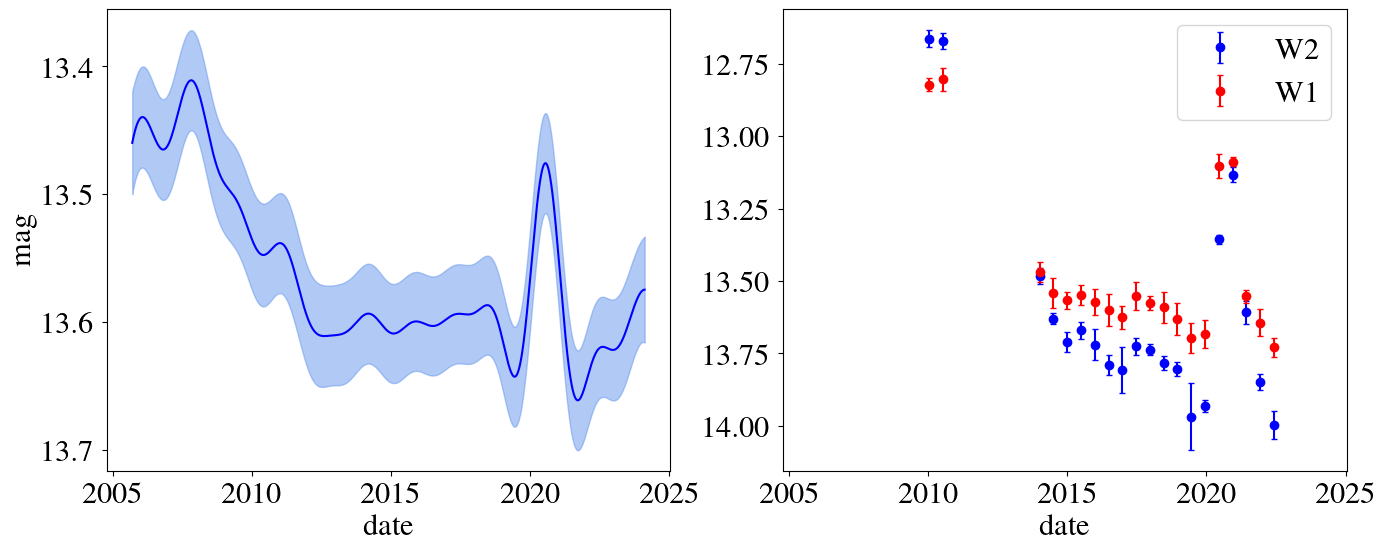

In [4]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].plot(test_gp['time'].to_value('decimalyear'), test_gp['mag'], c='blue')
ax[0].fill_between(test_gp['time'].to_value('decimalyear'), test_gp['mag']-test_gp['mag_err'], test_gp['mag']+test_gp['mag_err'], color='cornflowerblue', alpha=0.5)

ax[0].invert_yaxis()
ax[0].set_ylabel('mag')
ax[0].set_xlabel('date')

ax[1].errorbar(wise_obj_p2['time'].to_value('decimalyear'), wise_obj_p2['mag'], yerr=wise_obj_p2['mag_err'], linestyle='none', marker='o', capsize=2, color='b', label='W2')
ax[1].errorbar(wise_obj_p1['time'].to_value('decimalyear'), wise_obj_p1['mag'], yerr=wise_obj_p1['mag_err'], linestyle='none', marker='o', capsize=2, color='r', label='W1')

ax[1].legend()
ax[1].invert_yaxis()
ax[1].sharex(ax[0])
ax[1].set_xlabel('date')

In [40]:
class reverberation_mapper:

    def __init__(self, plateifu, optical_data=None, w1_data=None, w2_data=None):

        self.verbose = False
        self.plateifu = plateifu
        self.wise_band = None
        self.variable_kern_width = False

        if optical_data == None:

            try:
                self.optical_data, self.optical_GP = self.generate_optical_lightcurve()
                
                self.t_opt = self.optical_GP['time'].to_value('decimalyear')
                self.m_opt = self.optical_GP['mag']
                self.err_opt = self.optical_GP['mag_err']
                print('**Optical Data and GP Generated**')
            except:
                print('**Error: Unable to Generate Optical Data**')

        else:
            self.optical_GP = optical_data
            
            self.t_opt = self.optical_GP['time'].to_value('decimalyear')
            self.m_opt = self.optical_GP['mag']
            self.err_opt = self.optical_GP['mag_err']

        if w1_data == None or w2_data == None:

            try:
                self.w1, self.w2 = self.generate_wise_lightcurve()

                self.t_w1 = self.w1['time'].to_value('decimalyear')
                self.m_w1 = self.w1['mag']
                self.err_w1 = self.w1['mag_err']

                self.t_w2 = self.w2['time'].to_value('decimalyear')
                self.m_w2 = self.w2['mag']
                self.err_w2 = self.w2['mag_err']
                print('**IR Data Generated**')

            except:
                print('**Error: Unable to Generate IR Data**')

        else:
            self.w1, self.w2 = w1_data, w2_data

            self.t_w1 = self.w1['time'].to_value('decimalyear')
            self.m_w1 = self.w1['mag']
            self.err_w1 = self.w1['mag_err']

            self.t_w2 = self.w2['time'].to_value('decimalyear')
            self.m_w2 = self.w2['mag']
            self.err_w2 = self.w2['mag_err']

        self.preds_w1, self.chisq_w1, self.model1, self.const1, self.amp1 = [], [], [], [], []
        self.preds_w2, self.chisq_w2, self.model2, self.const2, self.amp2 = [], [], [], [], []

    def generate_wise_lightcurve(self):

        mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
        mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data 

        w1 = fp.process_wise(self.plateifu, mwv, band=1)
        w2 = fp.process_wise(self.plateifu, mwv, band=2)

        return w1, w2

    def generate_optical_lightcurve(self, l=[0.95, 1.05]):

        optical_lightcurve = lp.generate_combined_lightcurve(pifu=self.plateifu)

        poly_subtracted_obj_p, fit, fitted_poly = lp.polyfit_lightcurves(optical_lightcurve, deg=10)
        gp, llh, hyperparams, cov = lp.GP(poly_subtracted_obj_p, kernel_num=3, lengthscale=(l[0], l[1]))
        gp_fitted_poly =lp.make_polynomial(gp, fit)
        
        gp['mag']+=gp_fitted_poly
        print('**GP Kernel:', str(hyperparams)+'**')

        return optical_lightcurve, gp


    def hat(self, width):

        y = np.ones(width)
        y[0], y[-1] = 0, 0

        return y/np.nansum(y)


    def convolve(self, lag):

        kern_width = int(np.round(0.5*lag/np.nanmean(np.diff(self.t_opt)), 0))
        #print(kern_width)
        kern = self.hat(kern_width)

        conv = np.convolve(kern, self.m_opt-np.nanmedian(self.m_opt), mode='valid')
        t_conv = self.t_opt[(kern_width-1)//2:-(kern_width-1)//2]
        err_conv = self.err_opt[(kern_width-1)//2:-(kern_width-1)//2]
        return conv, t_conv, err_conv
    
    def fit_linear(self, conv, IR_data):

        def offset(x):
            a, c = x[0], x[1]
            conv_new = a * conv + c

            difference = conv_new - IR_data
            return difference
        
        amp, const = optimize.leastsq(offset, x0=[1, -50])

        return amp, const
    
    def predict_mags(self, params):
        
        lag = params

        if self.wise_band == 1:
            IR_data = self.w1
        if self.wise_band == 2:
            IR_data = self.w2

        conv, t_conv, err_conv = self.convolve(lag)

        inds = np.abs(IR_data['time'].to_value('decimalyear')[:, None] - (t_conv[None, :]+lag)).argmin(axis=-1)
        #print(inds)
        
        amp, const = self.fit_linear(conv[inds], IR_data['mag'])[0]

        model = amp * conv + const

        if self.verbose == True: #verbose option
            print(lag, amp, const)

        predicted_mags = model[inds]
        predicted_errs = err_conv[inds]

        if self.wise_band == 1:
            self.preds_w1.append(predicted_mags)
            self.model1.append(model)
            self.const1.append(const)
            self.amp1.append(amp)
        if self.wise_band == 2:
            self.preds_w2.append(predicted_mags)
            self.model2.append(model)
            self.const2.append(const)
            self.amp2.append(amp)

        return predicted_mags, predicted_errs

    def chisq(self, params):
        if self.wise_band == 1:
            IR_data = self.w1
        if self.wise_band == 2:
            IR_data = self.w2
            
        model_mags, model_errs = self.predict_mags(params)

        #norm_model_mags, norm_IR_data = model_mags - np.nanmean(model_mags), IR_data['mag'] - np.nanmean(IR_data['mag'])
        chisq = np.sum(((model_mags-IR_data['mag'])/model_errs)**2) #IR_data['mag_err']
        
        if self.wise_band == 1:
            self.chisq_w1.append(chisq)
        if self.wise_band == 2:
            self.chisq_w2.append(chisq)

        return chisq


    def minimize_chisq(self, kwargs):
        
        m = kwargs.get("model")
        x0 = kwargs.get("x0", [0.2, 1., 1.])
        niter = kwargs.get("niter", 100)
        T = kwargs.get("T", 1)
        stepsize = kwargs.get("stepsize", 0.5)
        ranges = kwargs.get("ranges")
        
        self.wise_band = kwargs.get("wise band")
        self.verbose = kwargs.get("verbose", False)

        if self.verbose == True:
            print(kwargs)
            
        if self.wise_band == 1:
            self.preds_w1, self.chisq_w1, self.model1, self.const1, self.amp1 = [], [], [], [], []
        if self.wise_band == 2:
            self.preds_w2, self.chisq_w2, self.model2, self.const2, self.amp2 = [], [], [], [], []

        if m == 'brute':
            model = optimize.brute(self.chisq, ranges=ranges, full_output=True, finish=optimize.minimize, disp=True)

        if m == 'basinhopping':
            minimizer_kwargs = { "method": "L-BFGS-B","bounds": ranges}
            model = optimize.basinhopping(self.chisq, x0=x0, stepsize=stepsize, niter=niter, T=T,minimizer_kwargs=minimizer_kwargs, callback=print_fun)

        if m == 'dualannealing':
            def print_fun(x, f, accepted):
                print("at minimum", str(x),  "with chisq:", str(f), "accepted:", int(accepted))

            #minimizer_kwargs = { "method": "L-BFGS-B","bounds": ranges}
            model = optimize.dual_annealing(self.chisq, bounds=ranges, callback=print_fun)

        #model = optimize.minimize(chisq, method='Nelder-Mead', x0=[0.2, 1, 1], bounds=((0.1, 5), (-np.inf,np.inf), (-np.inf, np.inf)))
        #ranges=(slice(0.01, 1, 0.01), slice(-100, 100, 0.1), slice(-100, 100, 0.1))
    
        return model


def ccf(optical_data, IR_data, wise_band):
    
    if wise_band == 1:
        m_accretion_disk = optical_data['mag'] * (0.16)**(1/3) ##Lyu 2019 paper, (nu_IR/nu_OPT)^(1/3) for W1

    if wise_band == 2:
        m_accretion_disk = optical_data['mag'] * (0.12)**(1/3) ##Lyu 2019 paper, (nu_IR/nu_OPT)^(1/3) for W2

    inds = np.abs(IR_data['time'].to_value('decimalyear')[:, None] - (optical_data['time'].to_value('decimalyear')[None, :])).argmin(axis=-1)
    ind_min = inds[0]
    print(inds)
    i = 0

    delta_t = np.mean(np.diff(optical_data['time'].to_value('decimalyear')))
    #print(delta_t)
    ccf = np.array([])
    time_lag = np.array([])

    IR_mags_norm, opt_mags_norm = IR_data['mag']-np.nanmean(IR_data['mag']), optical_data['mag']-np.nanmean(optical_data['mag'])
    while ind_min > 0:
        pearson_coeff= pearsonr(IR_mags_norm, opt_mags_norm[inds-i])[0]
        ccf = np.append(ccf, pearson_coeff)
        #print(pearson_coeff)
        lag = i * delta_t
        time_lag = np.append(time_lag, lag)
        
        ind_min = (inds-i)[0]
        i+=1
    return ccf, time_lag


In [41]:
pifu = '10223-3701'
RM = reverberation_mapper(pifu) 

##figures generated: '7981-9102', '10223-3701', '8341-12704', '8466-3704', '8561-3704', '7815-6104', '8091-9101'  


using padded times
**GP Kernel: 3.57**2 * RBF(length_scale=0.95) + WhiteKernel(noise_level=0.672)**
**Optical Data and GP Generated**
**IR Data Generated**


In [42]:
minimizer_args = {"model":'brute', "x0":[0.2], "ranges": (slice(0.04, 1.5, 0.01), ), "wise band": 1, "verbose": 1}
model1 = RM.minimize_chisq(minimizer_args)
m1 = model1[0]
print(m1)

{'model': 'brute', 'x0': [0.2], 'ranges': (slice(0.04, 1.5, 0.01),), 'wise band': 1, 'verbose': 1}
[0.04] 5.38440322128676 13.485536565859837
[0.05] 5.414589181555818 13.485958943065597
[0.06] 5.434471357459707 13.486082888273154
[0.07] 5.461764502582571 13.486516244115267
[0.08] 5.481668268126397 13.486672240810998
[0.09] 5.505687508341864 13.487115951283023
[0.1] 5.523844943609532 13.487301198521413
[0.11] 5.544086593570891 13.487753714333545
[0.12] 5.556095947954618 13.487887758325162
[0.13] 5.572687523992498 13.488346713206708
[0.14] 5.5792401591779335 13.488428166874213
[0.15] 5.592272246350973 13.488891104937972
[0.16] 5.597614710587502 13.489007671198301
[0.17] 5.606723074436725 13.489473017734937
[0.18] 5.6085578236664935 13.489618534894616
[0.19] 5.613289703688562 13.490083746590932
[0.2] 5.612278975390052 13.490185207381268
[0.21] 5.612906438523481 13.490648310910514
[0.22] 5.609013382448815 13.49070154636402
[0.23] 5.6057637171228265 13.491160572265938
[0.24] 5.5996706213168

In [45]:
conv_m_opt1, conv_t_opt1, err_opt1 = RM.convolve(m1[0])

a = np.where(RM.chisq_w1 == np.nanmin(RM.chisq_w1))[0][0]

print(m1, RM.amp1[a], RM.const1[a])

[0.23] 5.6057637171228265 13.491160572265938


Text(0.95, 0.05, '$M_{\\rm W1}(t)=5.61M_{\\rm OPT}(t-0.23)$')

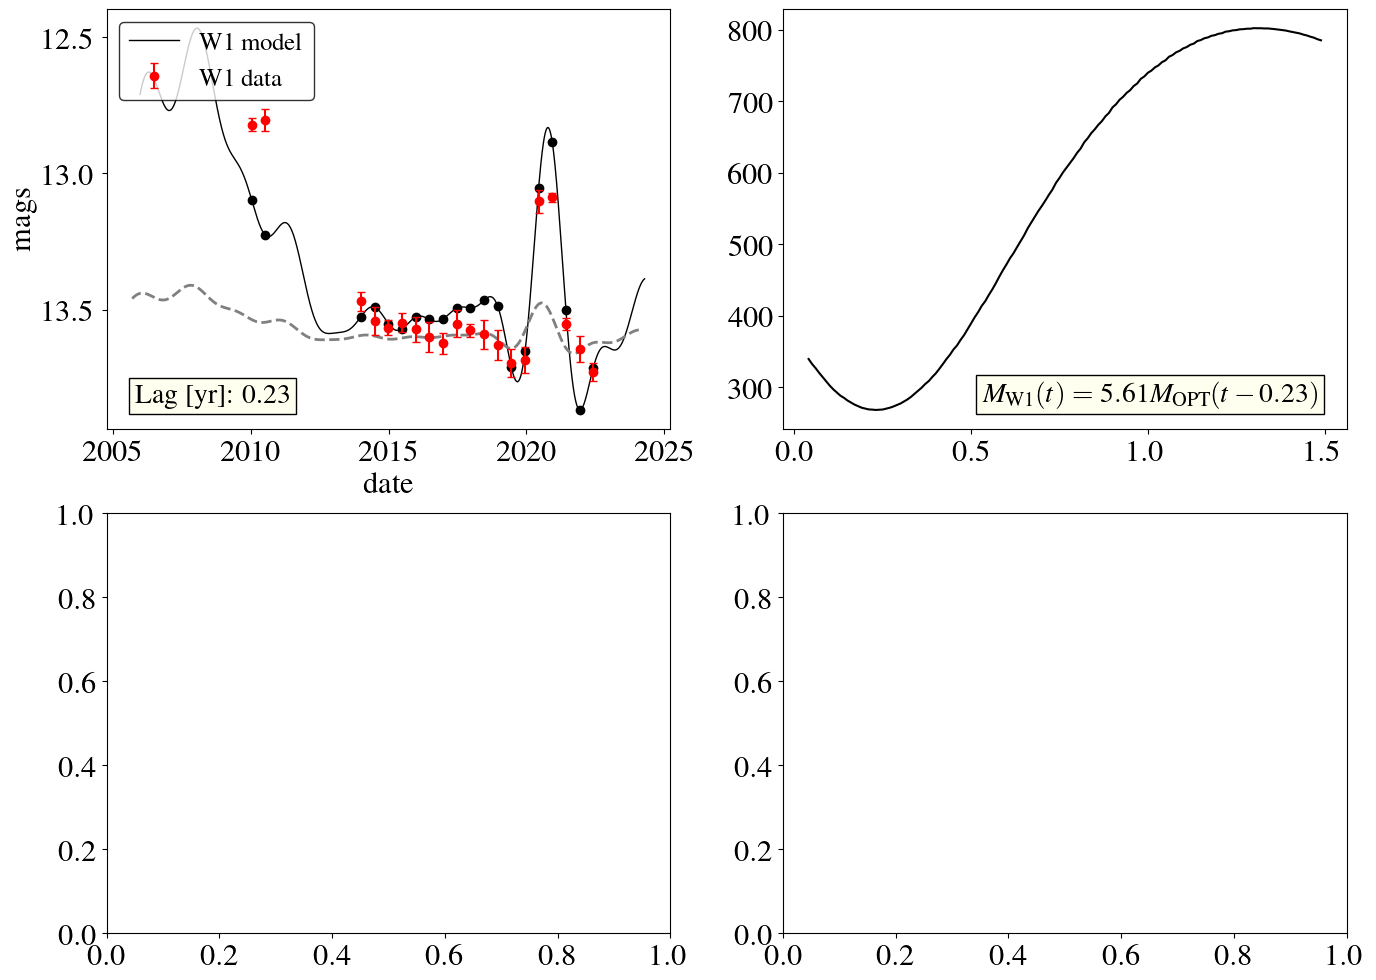

In [44]:
fig, ax = plt.subplots(figsize=(16,12), ncols=2, nrows=2)
ax[0, 0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
#ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m1[0], m1[1]*RM.optical_GP['mag']+m1[2]-RM.optical_GP['mag_err'], m1[1]*RM.optical_GP['mag']+m1[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

ax[0, 0].plot(conv_t_opt1+m1[0], RM.model1[a], c='k', lw=1, label='W1 model', zorder=-1)
ax[0, 0].scatter(RM.t_w1,  RM.preds_w1[a], c='k')
ax[0, 0].errorbar(RM.t_w1, RM.m_w1, yerr=RM.err_w1, c='red', capsize=3, linestyle='none', marker='o', label='W1 data')
ax[0, 0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m1[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[0, 0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)

ax[0, 0].invert_yaxis()
ax[0, 0].legend(edgecolor='k', loc='upper left', fontsize=18)
ax[0, 0].set_ylabel('mags')
ax[0, 0].set_xlabel('date')

ax[0, 1].plot(model1[2], model1[3], c='k')
ax[0, 1].text(0.95, 0.05, r'$M_{\rm W1}(t)='+str(np.round(RM.amp1[a], 2))+r'M_{\rm OPT}(t-'+str(np.round(m1[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[0, 1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)



In [1]:
minimizer_args = {"model":'brute', "x0":[0.2, 1, 1], "ranges": (slice(0.01, 0.4, 0.01), (1, 20, 0.1), (-100, 0, 1)), "wise band": 2, "verbose": True}
#minimizer_args = {"model":'dualannealing', "x0":[0.2, 1, 1], "ranges": ((0.1, m1[0]+0.5), (0.1, 10), (-200, 100)), "wise band": 2, "verbose": False}

In [406]:
model2 = RM.minimize_chisq(minimizer_args)
m2 = model2[0]
print(m2)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
#[  0.49   8.   -95.  ] -> minimized values for grid: (slice(0.01, 0.5, 0.01), (1, 100, 1), (-100, 100, 1)) ## ran in 8m 38s
#[   0.5    8.8 -106. ] -> minimized values for grid: (slice(0.01, 0.5, 0.01), (1, 10, 0.1), (-100, 100, 1)) ##ran in 8 mins 15 s

ccf_w2, lag_w2 = ccf(RM.optical_GP, RM.w2)
conv_m_opt2, conv_t_opt2 = RM.convolve(m2[0])

b = np.where(RM.chisq_w2 == np.nanmin(RM.chisq_w2))[0][0]
d = np.where(ccf_w2[:ccf_w2.size//2] == np.max(ccf_w2[:ccf_w2.size//2]))[0][0]


print(m2)

[0.5 1.3]


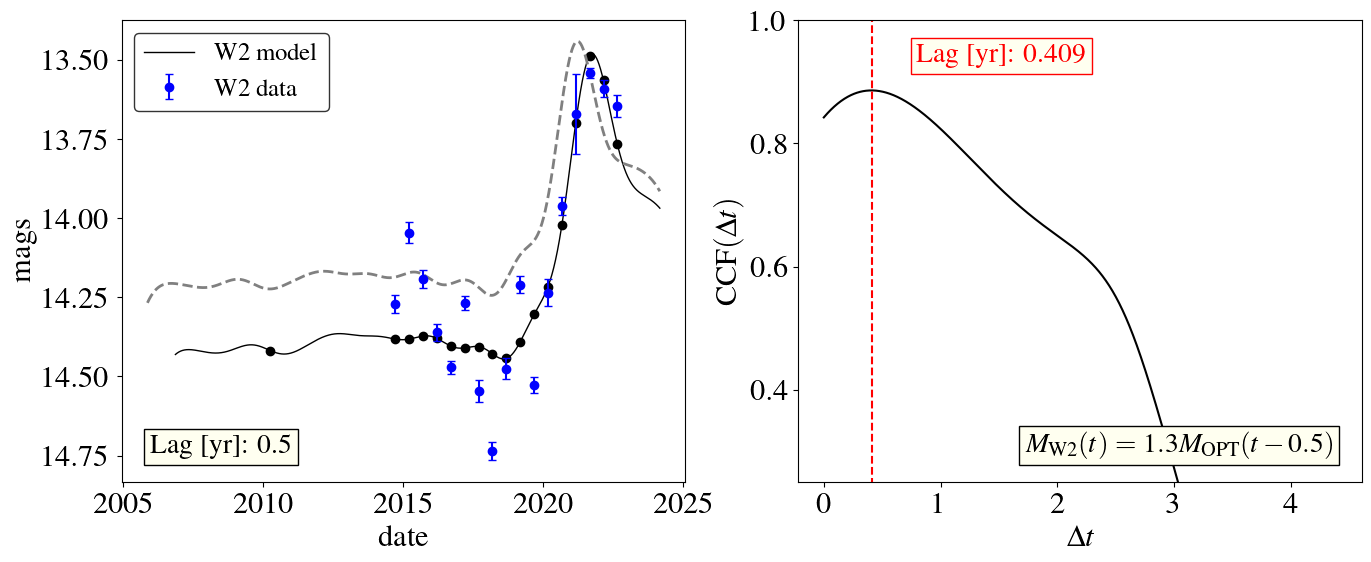

In [ ]:
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].plot(RM.optical_GP['time'].to_value('decimalyear'), RM.optical_GP['mag'], c='grey', lw=2, ls='dashed')
# ax[0].fill_between(RM.optical_GP['time'].to_value('decimalyear')+m2[0], m2[1]*RM.optical_GP['mag']+m2[2]-RM.optical_GP['mag_err'], m2[1]*RM.optical_GP['mag']+m2[2]+RM.optical_GP['mag_err'], color='cornflowerblue', alpha=0.5)

ax[0].plot(conv_t_opt2+m2[0], RM.model2[b], c='k', lw=1, label='W2 model', zorder=-1)
ax[0].scatter(RM.t_w2,  RM.preds_w2[b], c='k')
ax[0].errorbar(RM.t_w2, RM.m_w2, yerr=RM.err_w2, c='blue', capsize=3, linestyle='none', marker='o', label='W2 data')
ax[0].text(0.05, 0.05, 'Lag [yr]: '+str(np.round(m2[0],3)), ha='left', va='bottom', fontsize=20, transform=ax[0].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)


ax[0].invert_yaxis()
ax[0].legend(edgecolor='k', loc='upper left', fontsize=18)
ax[0].set_ylabel('mags')
ax[0].set_xlabel('date')
# ax[0].sharey(ax[0, 1])


ax[1].plot(lag_w2, ccf_w2, lw=1.5, c='k')
ax[1].vlines(lag_w2[d], 0, 1, color='r', ls='dashed')
ax[1].text(lag_w2[d]-0.2, 0.95, 'Lag [yr]: '+str(np.round(lag_w2[d],3)), ha='left', va='top', c='r', fontsize=20, transform=ax[1].transAxes, bbox=dict(facecolor='ivory', edgecolor='r', alpha=1), zorder=5)
ax[1].text(0.95, 0.05, r'$M_{\rm W2}(t)='+str(np.round(m2[1], 1))+r'M_{\rm OPT}(t-'+str(np.round(m2[0],3))+')$', ha='right', va='bottom', fontsize=20, transform=ax[1].transAxes, bbox=dict(facecolor='ivory', edgecolor='k', alpha=1), zorder=5)
   
ax[1].set_ylabel(r'CCF$(\Delta t)$')
ax[1].set_ylim(0.25, 1)
ax[1].set_xlabel(r'$\Delta t$')

#plt.savefig(SAVE_FILEPATH+'Reverb_Lags/const_separate/'+pifu+'_w2.png', bbox_inches = 'tight', pad_inches = 0.1, dpi = 300)

In [ ]:
def combine_img(plateifuv, fp1, fp2, save_fp, vertically=True):


    if vertically==True:
        for pifu in plateifuv:
            list_im = [fp1+pifu+'_w1.png', fp2+pifu+'_w2.png']
            imgs    = [ Image.open(i) for i in list_im ]
            # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
            min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
            imgs_comb = np.vstack([i.resize(min_shape) for i in imgs])

            # save that beautiful picture
            imgs_comb = Image.fromarray( imgs_comb)
            imgs_comb.save(SAVE_FILEPATH+save_fp+pifu+'.png')  
    else:
        for pifu in plateifuv:
            list_im = [fp1+pifu+'.png', fp2+pifu+'.png']
            imgs    = [ Image.open(i) for i in list_im ]
            # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
            min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
            imgs_comb = np.hstack([i.resize(min_shape) for i in imgs])

            # save that beautiful picture
            imgs_comb = Image.fromarray( imgs_comb)
            imgs_comb.save(SAVE_FILEPATH+save_fp+pifu+'.png')    


In [ ]:
fp1, fp2 ="C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/Reverb_Lags/const_separate/", "C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/Figures/Reverb_Lags/const_separate/"
save_fp = 'Reverb_Lags/const_separate/full_image/'
pifus = np.array(['7981-9102', '10223-3701', '8341-12704', '8466-3704', '8561-3704', '7815-6104', '8091-9101', '9870-9101', '9514-1901', '9487-3702', '8710-6102'])
combine_img(pifus, fp1, fp2, save_fp)